In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from itertools import combinations
import pyvoro
from alchex.geometry import PointCloud
import MDAnalysis as mda
import networkx as nx
%matplotlib notebook

In [37]:
pairing = PointCloud(3)
pairing.add_points(mda.Universe("data/popc_patch/sample.gro").select_atoms("name PO4").coordinates())

In [38]:
distances = pdist(pairing.points)
maxdist = 1
dists = []
quality = []
while maxdist < 30:
    dists.append(maxdist)
    g = nx.Graph()
    g.add_nodes_from(range(pairing.points.shape[0]))
    for i, (p1, p2) in enumerate(combinations(range(pairing.points.shape[0]), 2)):
        if distances[i] < maxdist:
            g.add_edge(p1, p2, length=distances[i])
    quality.append(np.mean([len(x) for x in nx.connected_component_subgraphs(g)])/maxdist)
    maxdist += 1
optimal_cutoff = dists[np.argmax(quality)]

g = nx.Graph()
g.add_nodes_from(range(pairing.points.shape[0]))
for i, (p1, p2) in enumerate(combinations(range(pairing.points.shape[0]), 2)):
    if distances[i] < optimal_cutoff:
        g.add_edge(p1, p2, length=distances[i])

In [39]:
for sg in nx.connected_component_subgraphs(g)

SyntaxError: invalid syntax (<ipython-input-39-9712ee68c293>, line 1)

In [40]:
# Random solver

from random import random, shuffle

k = KDTree(pairing.points)

solutions = []

best_so_far = None

for a in range(1000):
    g = nx.Graph()
    g.add_nodes_from(range(pairing.points.shape[0]))
    g.add_edges_from(k.query_pairs(11))
    pairs = []
    i = 0
    min_deg = [1,1]
    while True:
        deg = g.degree()
        di = deg.items()
        shuffle(di)
        min_deg = min(di, key=lambda x : x[1] if x[1] != 0 else 10000)
        i += 1
        n = min_deg[0]
        if min_deg[1] != 0:
            newpairs = g.edges(min_deg[0])
            min_deg_other = 10000
            min_other = -100
            shuffle(newpairs)
            for pair in newpairs:
                other = pair[1] if pair[1] != min_deg[0] else pair[0]
                d = deg[other]
                if d < min_deg_other:
                    min_deg_other = int(d)
                    min_other = other
            newpair = [min_deg[0], min_other]
            pairs.append(newpair)
            g.remove_nodes_from(newpair)
        if i > 2000 or len(g) == 0:
            break
    print(a)
    distance = 0
    if len(pairs) != 0:
        distances = [np.linalg.norm(pairing.points[p1] - pairing.points[p2]) for p1,p2 in pairs]
        distance = np.mean(distances)
    if best_so_far is None or (best_so_far[0] > len(g)) and (best_so_far[1] > distance):
        print(len(g), distance)
        best_so_far = (len(g), distance, g.nodes(), pairs)

0
(0, 8.2613727895629872)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


KeyboardInterrupt: 

In [41]:
# Random solver

from random import random, shuffle


def bruteforce_pair(points, maxiterations=100, d_max = 15, n_tol=0, d_tol=15):

    k = KDTree(points)

    solutions = []

    best_so_far = None

    for a in range(maxiterations):
        g = nx.Graph()
        g.add_nodes_from(range(pairing.points.shape[0]))
        g.add_edges_from(k.query_pairs(d_max))
        pairs = []
        i = 0
        min_deg = [1,1]
        while True:
            deg = g.degree()
            di = deg.items()
            shuffle(di)
            min_deg = min(di, key=lambda x : x[1] if x[1] != 0 else 10000)
            i += 1
            n = min_deg[0]
            if min_deg[1] != 0:
                newpairs = g.edges(min_deg[0])
                min_deg_other = 10000
                min_other = -100
                shuffle(newpairs)
                for pair in newpairs:
                    other = pair[1] if pair[1] != min_deg[0] else pair[0]
                    d = deg[other]
                    if d < min_deg_other:
                        min_deg_other = int(d)
                        min_other = other
                newpair = [min_deg[0], min_other]
                pairs.append(newpair)
                g.remove_nodes_from(newpair)
            if i > 2000 or len(g) == 0:
                break
        distance = 0
        if len(pairs) != 0:
            distances = [np.linalg.norm(pairing.points[p1] - pairing.points[p2]) for p1,p2 in pairs]
            distance = np.max(distances)
        if best_so_far is None or (best_so_far[0] > len(g)) and (best_so_far[1] > distance):
            best_so_far = (len(g), distance, g.nodes(), pairs)
            if len(g) <= n_tol and distance <= d_tol:
                break
    return best_so_far[3], best_so_far[2], distance
            
pairs, unpaired, mean_distance = bruteforce_pair(pairing.points, d_max=11)

In [42]:
pairing.lines = pairs

<IPython.core.display.Javascript object>


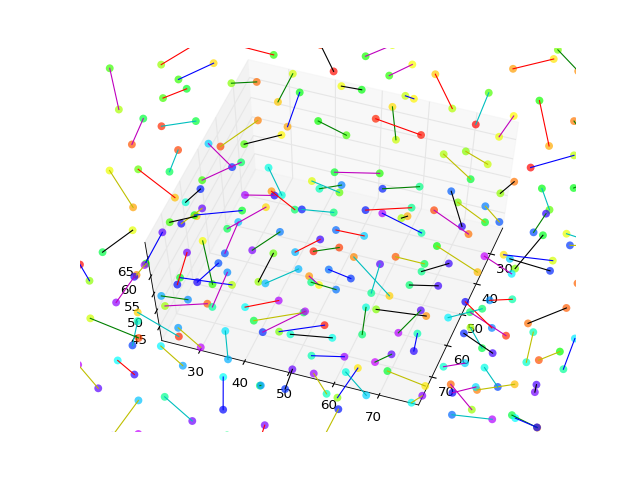

In [43]:
pairing.plot()

In [1]:
x = 1
y = 2

2x + 1y = 3
1y + 2x = 4

In [11]:
np.linalg.solve(
    [
        [2,1],
        [1,2]
    ],[3,4]
)

array([ 0.66666667,  1.66666667])

In [46]:
# fname tname f t
ratios = [
("P", "D", 1, 1),
 ("C", "D", 1, 2),
 ("P", "C", 2, 1),
 ("P", "L", 3, 1),
 ("C", "P", 1, 2),
 ("C", "L", 3, 2),
 ("C", "C", 1, 1)
]
r = {}
for k, v, l, m in ratios:
    if k not in r:
        r[k] = {}
    if v not in r[k]:
        r[k][v] = (l,m)
init_counts = {"P" : 50, "C" : 50}
desired_counts = {"D" : 0.3, "C" : 0.4, "L" : 0.8}

baseunits = 
for inm, inn in init_counts.items():
    for dnm, dnn in desired_counts.items():
        r1, r2 = r[inm][dnm]
        if r2 > 1:
            print(r1, r2)
        #r1 of inm = r2 of dnm
        
        
        

(1, 2)
(3, 2)


In [5]:
r

{'C': {'D': (1, 2), 'L': (3, 2), 'P': (1, 2)},
 'P': {'C': (2, 1), 'D': (1, 1), 'L': (3, 1)}}

In [19]:
import numpy as np
import networkx as nx

In [21]:
d = nx.DiGraph()

In [28]:
for k, v, l, m in ratios:
    d.add_node(k)
    d.add_node(v)
for k, v, l, m in ratios:
    d.add_edge(k, v)

<IPython.core.display.Javascript object>


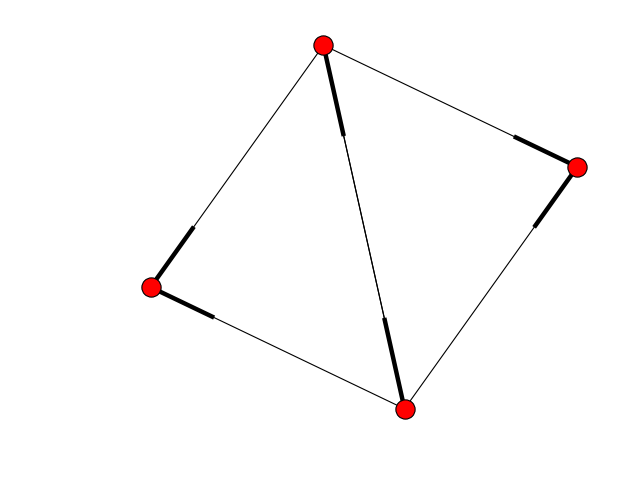

In [29]:
nx.draw(d)

In [33]:
nx.shortest_path(d, "C", "L")

['C', 'L']